# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План.**
1. [Загрузка данных и изучение общей информации.](#section_id_1)
2. [Предобработка данных.](#section_id_2)</br>
* 2.1. Работа с пропусками.</br>
* 2.2. Работа с типом данных.</br>
* 2.3. Работа с дубликатами.</br>
* 2.4. Работа с аномальными значениями.</br>
3. [Добавление новых столбцов.](#section_id_3)
4. [Исследовательский анализ данных.](#section_id_4)
* 4.1. Изучение некоторых параметров квартир.</br>
* 4.2. Насколько быстро продавались квартиры.</br>
* 4.3. Какие факторы больше всего влияют на общую (полную) стоимость объекта.</br>
* 4.4. Посчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.</br>
* 4.5. Подсчет средней цены 1 км. в городе Санкт-Петербург.</br>
5. [Общий вывод.](#section_id_5)

**Описание данных**</br>
* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)</br>
* `balcony` — число балконов</br>
* `ceiling_height` — высота потолков (м)</br>
* `cityCenters_nearest` — расстояние до центра города (м)</br>
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)</br>
* `first_day_exposition` — дата публикации</br>
* `floor` — этаж</br>
* `floors_total` — всего этажей в доме</br>
* `is_apartment` — апартаменты (булев тип)</br>
* `kitchen_area` — площадь кухни в квадратных метрах (м²)</br>
* `last_price` — цена на момент снятия с публикации</br>
* `living_area` — жилая площадь в квадратных метрах (м²)</br>
* `locality_name` — название населённого пункта</br>
* `open_plan` — свободная планировка (булев тип)</br>
* `parks_around3000` — число парков в радиусе 3 км</br>
* `parks_nearest` — расстояние до ближайшего парка (м)</br>
* `ponds_around3000` — число водоёмов в радиусе 3 км</br>
* `ponds_nearest` — расстояние до ближайшего водоёма (м)</br>
* `rooms` — число комнат</br>
* `studio` — квартира-студия (булев тип)</br>
* `total_area` — общая площадь квартиры в квадратных метрах (м²)</br>
* `total_images` — число фотографий квартиры в объявлении</br>

## 1. Загрузка данных и изучение общей информации.<a id='section_id_1'></a>

* Откроем файл с данными и выведем 5 строчек таблицы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('real_estate_data.csv', sep ='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
a = data.shape[0]
a

23699

## 2. Предобработка данных.<a id='section_id_2'></a>

### 2.1. Работа с пропусками.

* Посчитаем количество пропусков.

In [4]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Количество пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось')

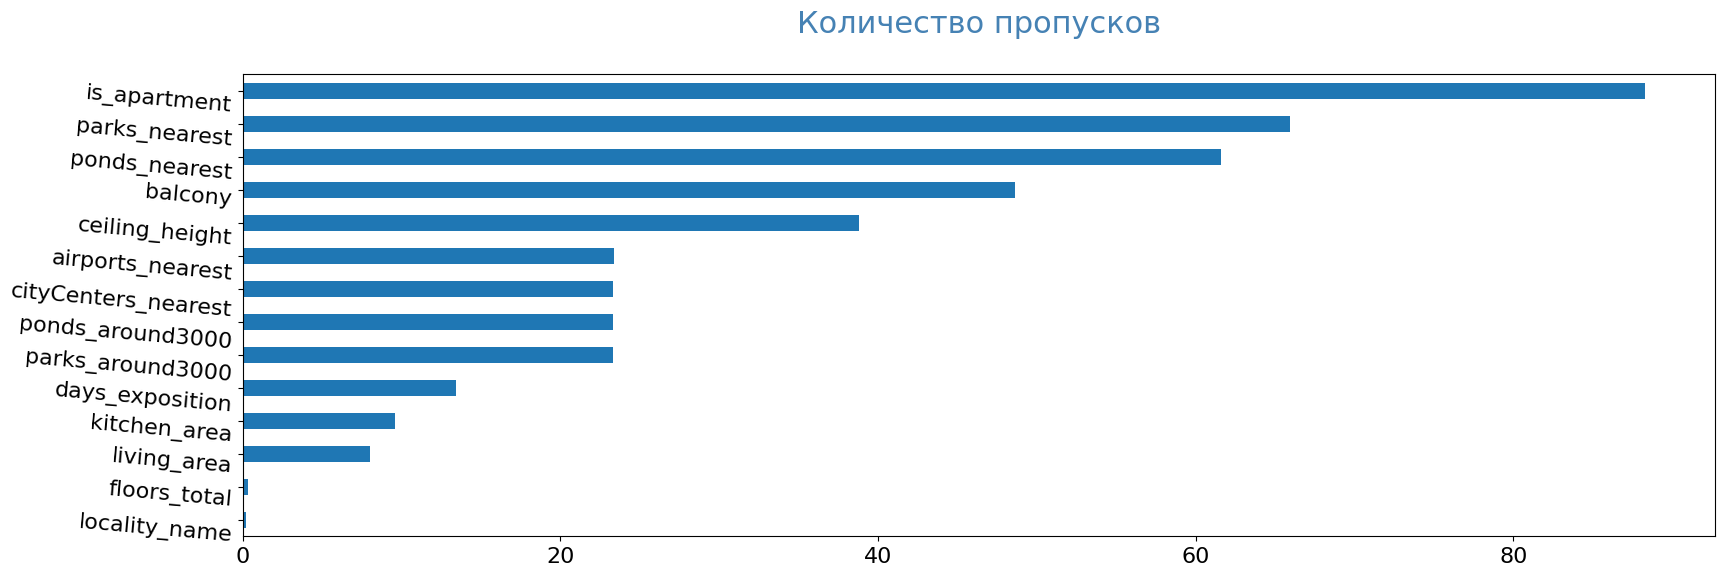

In [5]:
pass_value_barh(data)

Данные пропущены в столбцах: 
* высота потолков,
* количество этажей в доме,
* жилая площадь,
* булев тип - апартаменты,
* площадь кухни,
* число балконов,
* название населённого пункта,
* расстояние до ближайшего аэропорта,
* расстояние до центра города,
* число парков в радиусе 3 км,
* расстояние до ближайшего парка,
* число водоёмов в радиусе 3 км,
* расстояние до ближайшего водоёма,
* количество дней, в течение которых было размещено объявление

* Рассмотрим пропуски в категории данных **высота потолков**. Выведем количество пропусков в городе Санкт-Петербург и других городах.

In [6]:
table_Spb = data.query('locality_name == "Санкт-Петербург"')
table_rest = data.query('locality_name != "Санкт-Петербург"')
print('Сенкт-Петербург', table_Spb['ceiling_height'].isna().sum())
print('Другие города', table_rest['ceiling_height'].isna().sum())

Сенкт-Петербург 5617
Другие города 3578


* Выпишем уникальные значения высоты потолков.

In [7]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

* Рассмотрим квартиры Санкт-Петербурга. Введём первое ограничение на высоту - 40 метров. И построим график высоты потолков в зависимости от удалённости от центра города.

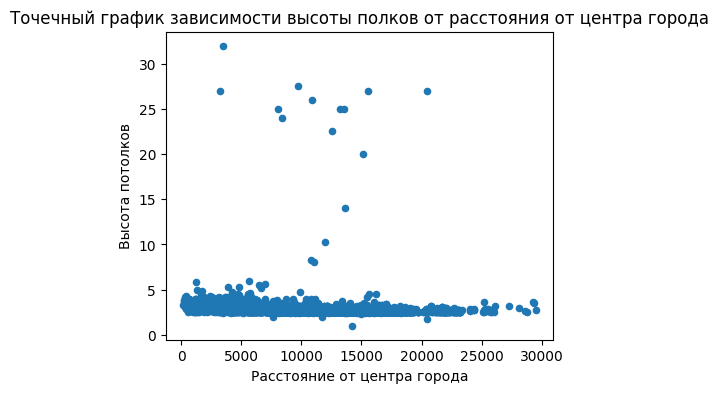

In [8]:
table_Spb = table_Spb.query('ceiling_height < 40')
table_Spb.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', figsize=(5, 4))
plt.title('Точечный график зависимости высоты полков от расстояния от центра города')
plt.xlabel('Расстояние от центра города')
plt.ylabel('Высота потолков')
plt.show()

* Выведем на экран квартиры, у которых высота потолков превышает 10 метров.

In [9]:
table_Spb.query('ceiling_height > 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5669,4,4400000.0,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,NaN,...,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
9379,5,3950000.0,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,NaN,...,5.2,NaN,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,NaN,...,9.1,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
17496,15,6700000.0,92.9,2019-02-19T00:00:00,3,20.0,17.0,53.2,14,NaN,...,12.0,5.0,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN
17857,1,3900000.0,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,...,NaN,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0
18545,6,3750000.0,43.0,2019-03-18T00:00:00,2,25.0,5.0,29.0,3,False,...,NaN,NaN,Санкт-Петербург,27054.0,8033.0,1.0,540.0,0.0,NaN,12.0
20478,11,8000000.0,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,NaN,...,10.0,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0


Данных квартир не очень много. Скорее всего была сделана опечатка при вводе данных. Исправим значения.

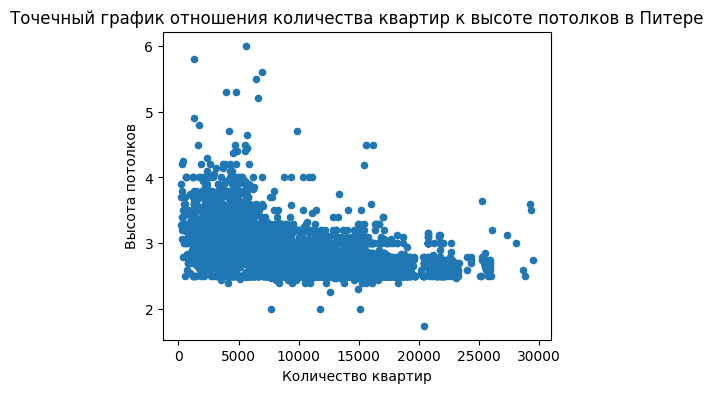

In [10]:
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(25, 2.5)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(24, 2.4)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(26, 2.6)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(27, 2.7)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(20, 2.0)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(22.6, 2.26)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(27.5, 2.75)
table_Spb['ceiling_height'] = table_Spb['ceiling_height'].replace(32, 3.2)
pd.set_option('mode.chained_assignment', None)
table_Spb = table_Spb.query('1.5 < ceiling_height < 8')
table_Spb.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', figsize=(5, 4))
plt.title('Точечный график отношения количества квартир к высоте потолков в Питере')
plt.xlabel('Количество квартир')
plt.ylabel('Высота потолков')
plt.show()

* Посмотрим на связь удалённости от центра города и высоту потолков в квартирах в других городах.

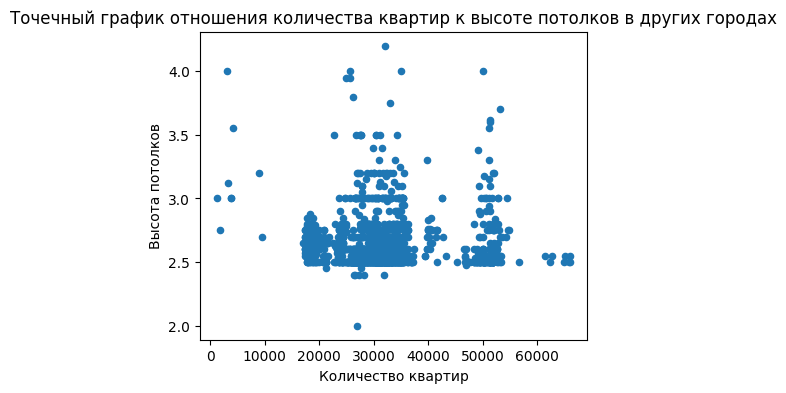

In [11]:
table_rest = table_rest.query('ceiling_height < 8')
table_rest.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', figsize=(5, 4))
plt.title('Точечный график отношения количества квартир к высоте потолков в других городах')
plt.xlabel('Количество квартир')
plt.ylabel('Высота потолков')
plt.show()

По графику квартир Питера хорошо видно, что квартиры с высокими потолками находятся в исторической части города. Четкой закономерности на графике остальных городов не наблюдается. Чтобы заполнить пропуски разделим датасет на 3 части (центр, город и пригород) и далее заполним пропуски по частям медианным значением.

In [12]:
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(24, 2.4)
data['ceiling_height'] = data['ceiling_height'].replace(26, 2.6)
data['ceiling_height'] = data['ceiling_height'].replace(27, 2.7)
data['ceiling_height'] = data['ceiling_height'].replace(20, 2.0)
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.26)
data['ceiling_height'] = data['ceiling_height'].replace(27.5, 2.75)
data['ceiling_height'] = data['ceiling_height'].replace(32, 3.2)
pd.set_option('mode.chained_assignment', None)

def proximity_to_center(each):
    try:
        if each['locality_name'] == 'Санкт-Петербург' and each['cityCenters_nearest'] < 7500:
            return 'Центр Питера'
        elif each['locality_name'] == 'Санкт-Петербург' and 7500 <= each['cityCenters_nearest'] < 15000:
            return 'Питер'
        elif each['locality_name'] == 'Санкт-Петербург' and each['cityCenters_nearest'] >= 15000:
            return 'Пригород Питера'
        else:
            return 'Другой населённый пункт'
    except:
        pass
            
data['proximity_to_center'] = data.apply(proximity_to_center, axis = 1)

#заполняем пропуски медианами в зависимости от группы отдалённости от центра
for t in data['proximity_to_center'].unique():
    data.loc[(data['proximity_to_center'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['proximity_to_center'] == t), 'ceiling_height'].median()
    
data['ceiling_height'].isna().sum()

0

* Рассмотрим пропуски в категории данных **количество этажей в доме**. Выведем уникальные значения количества этажей.

In [13]:
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

* Посчитаем количество пропусков.

In [14]:
data['floors_total'].isna().sum()

86

* Предположим, что пропуски можно заполнить значением в столбце этаж. Тогда сколько таких строк, в которых пропуск в floors_total и floor = 1?

In [15]:
df_1 = data.copy(deep=True)
df_1['floors_total'] = df_1['floors_total'].fillna('-')
df_1.query('floors_total == "-" and floor == 1')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,proximity_to_center
237,4,2438033.0,28.10,2016-11-23T00:00:00,1,2.6,-,20.75,1,NaN,...,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0,Пригород Питера
3817,1,1640000.0,23.98,2015-08-25T00:00:00,1,2.6,-,NaN,1,NaN,...,0.0,посёлок Щеглово,61908.0,34085.0,0.0,NaN,0.0,NaN,378.0,Другой населённый пункт
15989,1,4100000.0,74.50,2017-04-22T00:00:00,3,2.6,-,NaN,1,NaN,...,0.0,Красное Село,25382.0,28806.0,0.0,NaN,0.0,NaN,72.0,Другой населённый пункт


Данных, в которых floors_total = Nan и  floor = 1 всего 3 строчки. Это не повлияет на гипотезу.

In [16]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])
data['floors_total'].isna().sum()

0

* Посмотрим на пропуски в категории **жилая площадь** и **кухня**.

In [17]:
print('Жилая площадь', data['living_area'].isna().sum())
print('Кухня', data['kitchen_area'].isna().sum())
print('Общая площадь', data['total_area'].isna().sum())

Жилая площадь 1903
Кухня 2278
Общая площадь 0


In [18]:
print('Наименьшая жилая площадь', data['living_area'].min())
print('Наибольшая жилая площадь', data['living_area'].max())

Наименьшая жилая площадь 2.0
Наибольшая жилая площадь 409.7


* Посчитаем сколько квартир имеют пропуски и в жилой площади и в площади кухни.

In [19]:
df_2 = data.copy(deep=True)
df_2['living_area'] = df_2['living_area'].fillna('-')
df_2['kitchen_area'] = df_2['kitchen_area'].fillna('-')
len(df_2.query('living_area == "-" and living_area == "-"'))

1903

* Посмотрим сколько квартир с пропусками в площадях имеют свободну планировку или являются студиями.

In [20]:
len(df_2.query(
    '(living_area == "-" and living_area == "-") and (open_plan or studio == True)'
))

15

Пропуски практически не совпадают ни с указанием, что это квартира-студия, ни с упоминанием, что квартира имеет отрытую планировку. То есть пропуски нельзя заполнить корректно, не исказив данные, поэтому оставляем их.

* Пропуски в **количестве балконов**, **числе парков** и **числе водоймов**.

In [21]:
print('Количенство балконов', data['balcony'].isna().sum())
print('Парки', data['parks_around3000'].isna().sum())
print('Пруды', data['ponds_around3000'].isna().sum())

Количенство балконов 11519
Парки 5518
Пруды 5518


Если количество балконов в данных пропущено, то скорее всего их нет. С числом парков и водоёмов аналогично.

In [22]:
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
print(data['balcony'].isna().sum())
print(data['parks_around3000'].isna().sum())
print(data['ponds_around3000'].isna().sum())

0
0
0


* Пропуски в расстоянях до 
  * **ближайшего аэропорта**,
  * **центра города**,
  * **ближайшего парка**,
  * **ближайшего водоёма**.

In [23]:
print('До аэропорта', data['cityCenters_nearest'].isna().sum())
print('До города', data['cityCenters_nearest'].isna().sum())
print('До парка', data['parks_nearest'].isna().sum())
print('До водоёма', data['ponds_nearest'].isna().sum())

До аэропорта 5519
До города 5519
До парка 15620
До водоёма 14589


Заполним пропуски медианным значением для каждой категории города.

In [24]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('median'))
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby('locality_name')['airports_nearest'].transform('median'))
data['parks_nearest'] = data['parks_nearest'].fillna(data.groupby('locality_name')['parks_nearest'].transform('median'))
data['ponds_nearest'] = data['ponds_nearest'].fillna(data.groupby('locality_name')['ponds_nearest'].transform('median'))
data['parks_around3000'] = data['parks_around3000'].fillna(data.groupby('locality_name')['parks_around3000'].transform('median'))
data['ponds_around3000'] = data['ponds_around3000'].fillna(data.groupby('locality_name')['ponds_around3000'].transform('median'))
print('Количество пропусков в категории расстояние до центра города:', data['cityCenters_nearest'].isna().sum())
print('Количество пропусков в категории расстояние до ближайшего аэропорта:', data['cityCenters_nearest'].isna().sum())
print('Количество пропусков в категории расстояние до ближайшего парка:', data['parks_nearest'].isna().sum())
print('Количество пропусков в категории расстояние до ближайшего водоёма:', data['ponds_nearest'].isna().sum())

Количество пропусков в категории расстояние до центра города: 5394
Количество пропусков в категории расстояние до ближайшего аэропорта: 5394
Количество пропусков в категории расстояние до ближайшего парка: 6032
Количество пропусков в категории расстояние до ближайшего водоёма: 5518


Пропуски заполнились не полностью. Скорее всего это связано с тем, что в названии города так же пропуск.

* Посмотрим на количество пропусков в категориях:
  * **апартаменты**,
  * **название населённого пункта**,
  * **количество дней, в течение которых было размещено объявление**.

In [25]:
print('Апартаменты', data['is_apartment'].isna().sum())
print('Название населённого пункта', data['locality_name'].isna().sum())
print('Кол-во дней', data['days_exposition'].isna().sum())

Апартаменты 20924
Название населённого пункта 49
Кол-во дней 3181


Данные в булевом типе аппартаменты имеют много пропусков. Скорее всего это связано с тем, что квартиры не являются аппартаментами. 
Пропуски в оставшихся двух категориях заполнить затруднительно.

In [26]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

### 2.2. Работа с типом данных.

Выведем общую информацию о таблице.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

* Произведем замену типов данных.
  * **Дата публикации** - date.
  * **Всего этажей в доме** - int.
  * **Аппартаменты** - bool.
  * **Количество балконов** - int.

In [28]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')

### 2.3. Работа с дубликатами.

* Посчитаем количество уникальных значений в названиях населённых пунктов.

In [29]:
len(data['locality_name'].unique())

365

* Проверим данные на явные дубликаты.

In [30]:
display(data.duplicated().sum())

0

* Избавимся от предположительных неявных дубликатов.

In [31]:
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
len(data['locality_name'].unique())

331

### 2.3. Работа с аномальными значениями.

* **Балконы**

In [32]:
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

In [33]:
len(data.query('balcony >3 and total_area <50'))

48

Данные, в которых больше 3х балконов и площадь менее 50 кв.м. выглядят неправдоподо. Рассчитаем сколько процентов составляют такие квартиры.

In [34]:
round(data.query('balcony > 3 and total_area < 50').shape[0]/data.shape[0]*100, 3)

0.203

В силу малости таких данных их можно исключить из нашего анализа.

In [35]:
data = data.query('not (balcony > 3 and total_area < 50)')

* **Высота потолков**

Посмотрим на границы значений высоты потолков в квартирах.

In [36]:
print(data['ceiling_height'].min())
print(data['ceiling_height'].max())

1.0
14.0


Очевидно, что потолки в 20-100 метров могут быть только в старинных замках. В наших значениях таких порядков быть не может, поэтому поработаем с аномальными значениями в этой категории. В домах старой застройки (дореволюционные и довоенные) можно встретить высоту потолков в 3-4 метра. Такие же характеристики установлены и в сталинках. В последних параметр иногда превышает 4 м, поэтому поставим верхнюю границу для потолков 4 метра, а нижнюю - 2,2 метра. Посчитаем количество аномальных значений в данных с указанными пределами. Так же определим процент аномальных значений из всего датафрейма.

In [37]:
print('Потолки выше 4м:', data[data['ceiling_height'] > 4].shape[0])
print('Потолки ниже 2.2:', data[data['ceiling_height'] < 2.2].shape[0])
print('Процент аномальных значений:', 
      round(data.query('ceiling_height > 4 or ceiling_height < 2.2').shape[0]/data.shape[0]*100, 2))

Потолки выше 4м: 52
Потолки ниже 2.2: 15
Процент аномальных значений: 0.28


Аномальных значений оказалось меньше половины процента, поэтому исключим данные значения из нашего анализа

In [38]:
data = data.query('not (ceiling_height > 4 or ceiling_height < 2.2)')

* **Этаж** и **количество этажей в доме**.

Посмотрим на максимальное и минимальное число в категории **этаж**.

In [39]:
print(max(data['floor']))
print(min(data['floor']))

33
1


Аномальных значений не выявлено.

Выведем максимальное и минимальное **число этажей в доме**.

In [40]:
print(max(data['floors_total']))
print(min(data['floors_total']))

60
1


60 этажей выглядят подозрительно. Самый крупный город из выборки - Санкт-Петербург. Самое высокое жилое здание в данном городе имеет этажность 37. Посмотрим сколько значений в таблице выбивается из этой границы.

In [41]:
data[data['floors_total'] > 37]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,proximity_to_center
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0,Другой населённый пункт
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,0,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,503.0,45.0,Питер


Их всего 2. Избавимся от этих зданий.

In [42]:
data = data.query('floors_total <= 37')

* **Площадь.**

Выведем максимальные и минимальные значения для категорий **кухня**, **жилая площадь** и **общая площадь**.

In [43]:
print('Кухня')
print(max(data['kitchen_area']))
print(min(data['kitchen_area']))
print('Жилая площадь')
print(max(data['living_area']))
print(min(data['living_area']))
print('Общая площадь')
print(max(data['total_area']))
print(min(data['total_area']))

Кухня
112.0
1.3
Жилая площадь
409.7
2.0
Общая площадь
900.0
12.0


Общая площадь в 900 кв.м. выглядит неправдоподобно. Посмотрим сколько таких квартир.

In [44]:
len(data[data['total_area'] > 500])

6

Исключим их из датафрейма.

In [45]:
data = data.query('total_area < 500')
data.shape

(23574, 23)

Проверим есть ли квартиры, у которых общая площадь меньше жилой + кухня, но без студий и свободной планировки. Но оставим небольшую возможность заполнителям ошибиться в сумме.

In [46]:
len(data.loc[((data['total_area']*1.1 < ((data['living_area'] + data['kitchen_area']))) &
          (data['studio'] == False) & (data['open_plan'] == False))])

36

Такие данные выглядят ненадёжно. В силу малости их процента от общей таблицы исключим их из датафрейма.

In [47]:
data = data.loc[~(((data['total_area']*1.1 < ((data['living_area'] + data['kitchen_area']))) &
          (data['studio'] == False) & (data['open_plan'] == False)))]
data.shape

(23538, 23)

 Построим диаграммы размаха для значений площадей и выведем описания выборок.

count    23538.000000
mean        60.053944
std         33.510241
min         12.000000
25%         40.000000
50%         52.000000
75%         69.747500
max        494.100000
Name: total_area, dtype: float64

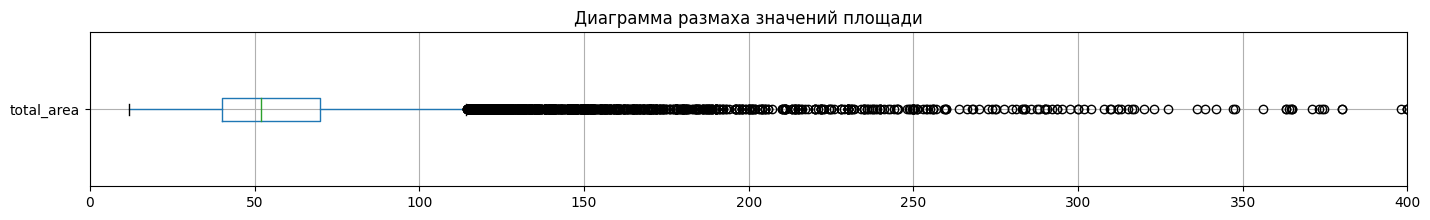

In [48]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);
data['total_area'].describe()

count    21275.000000
mean        10.528374
std          5.764535
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

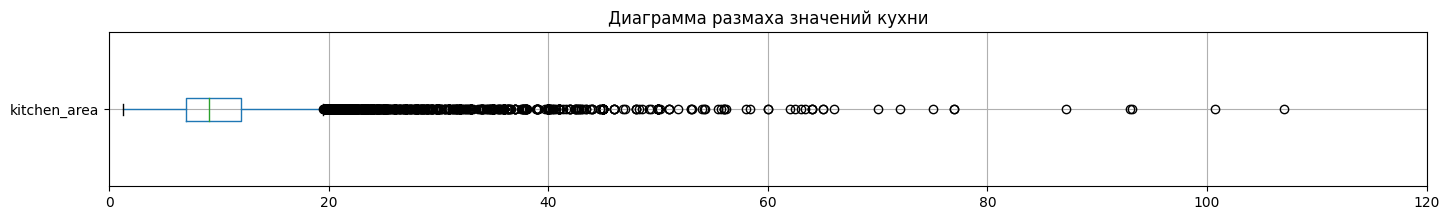

In [49]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений кухни')
ax.set_xlim(0, 120);
data['kitchen_area'].describe()

count    21649.000000
mean        34.304986
std         21.132751
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        312.500000
Name: living_area, dtype: float64

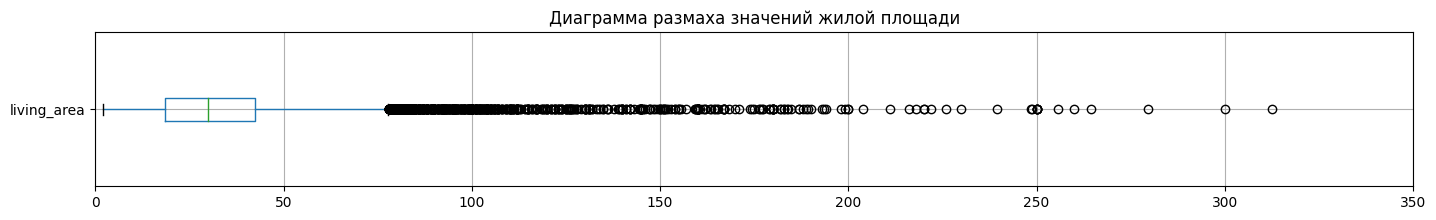

In [50]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0, 350);
data['living_area'].describe()

На диаграммах хорошо видны выбивающиеся значения. Для общей площади установим границы в 20-250 метров, для кухни - 5-60 метров, для жилой площади 5-200 метров.

In [51]:
data = data.query('20 < total_area < 250')
data.drop(data[data['kitchen_area'] > 60].index, inplace=True)
data.drop(data[data['kitchen_area'] < 5].index, inplace=True)
data.drop(data[data['living_area'] > 200].index, inplace=True)
data.drop(data[data['living_area'] < 5].index, inplace=True)

* **Числом комнат.**

Рассмотрим диаграмму размаха для значения числа комнат.

count    23283.000000
mean         2.055148
std          1.026686
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64

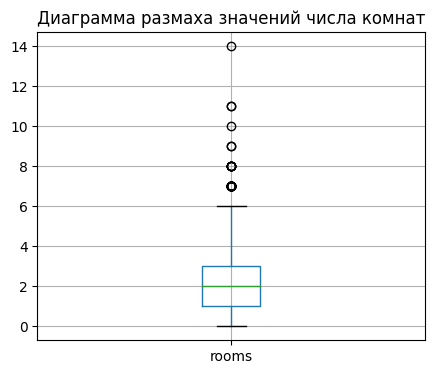

In [52]:
fig, ax = plt.subplots(figsize = (5,4))
ax = data.boxplot('rooms')
ax.set_title('Диаграмма размаха значений числа комнат')
data['rooms'].describe()

Посмотрим сколько данных находятся в верхних границах.

In [53]:
data['rooms'].value_counts()

1     7906
2     7852
3     5757
4     1161
5      292
0      184
6       81
7       37
8        7
9        2
11       2
10       1
14       1
Name: rooms, dtype: int64

Посмотрим внимательнее на площадь квартир, которые содержат много комнат.

In [54]:
print(data[data['rooms'] > 6]['total_area'].max())
print(data[data['rooms'] > 6]['total_area'].min())

249.9
100.6


Площади достаточно большие, но число комнат больше 8 явно аномальное и находится далеко от "усов" диаграммы размаха. Посчитаем сколько строк в датафрейме приходится на большое количество комнат.

In [55]:
len(data[data['rooms'] > 8])

6

Отбросим эти значения в силу их малого количества.

In [56]:
data = data.query('rooms < 8')

* **Число парков и прудов.**

In [57]:
print('Парки')
print(max(data['parks_around3000']))
print(min(data['parks_around3000']))
print('Пруды')
print(max(data['ponds_around3000']))
print(min(data['ponds_around3000']))

Парки
3.0
0.0
Пруды
3.0
0.0


Значения вполне нормальные.

* **Количество дней, в течение которых было размещено объявление**

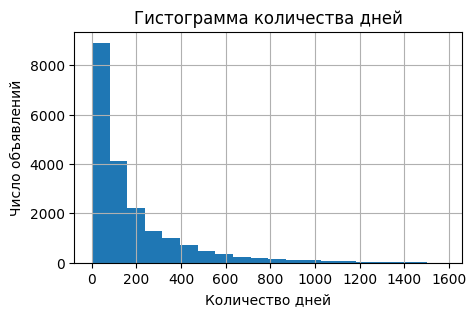

In [58]:
fig, ax = plt.subplots(figsize = (5,3))
ax = data['days_exposition'].hist(bins=20)
ax.set_title('Гистограмма количества дней')
ax.set_xlabel('Количество дней')
ax.set_ylabel('Число объявлений');

count    20151.000000
mean       180.273336
std        218.914697
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

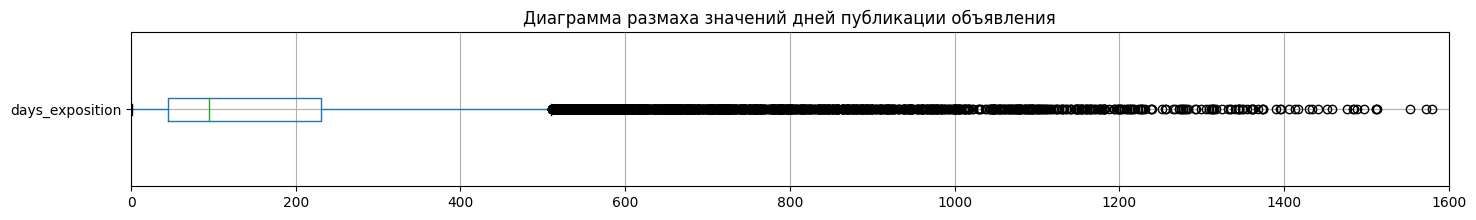

In [59]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений дней публикации объявления')
ax.set_xlim(0, 1600);
data['days_exposition'].describe()

In [60]:
len(data[data['days_exposition'] < 5])

332

Данных, которые отражают больше 1000 дней совсем малое количество. Так же значения < 5 дней выглядят неправдоподобно. Исключим их из датафрейма.

In [61]:
data.drop(data[data['days_exposition'] > 1000].index, inplace=True)
data.drop(data[data['days_exposition'] < 5].index, inplace=True)
data.shape

(22670, 23)

* **Цена**

Построим диаграмму размаха для цены квартир.

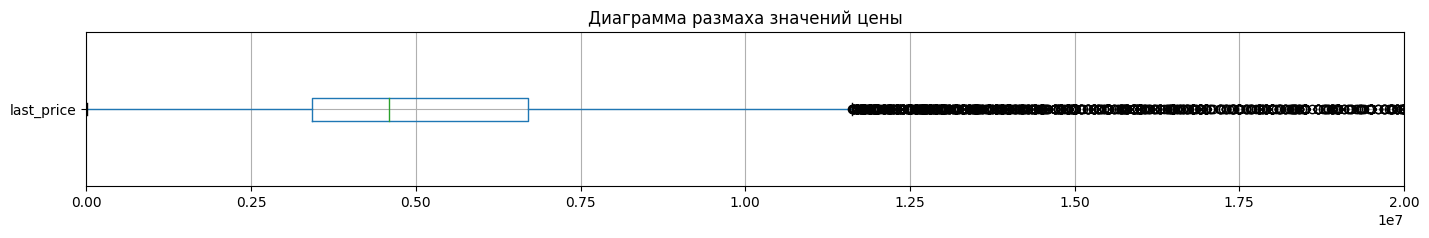

In [62]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений цены')
ax.set_xlim(0, 20000000);

Посчитаем количество квартир с ценой более 18млн и менее 0,5млн.

In [63]:
print('Более 18млн.:', len(data.query('last_price > 18000000')))
print('Менее 500тыс.:', len(data[data['last_price'] < 500000]))

Более 18млн.: 693
Менее 500тыс.: 14


In [64]:
data = data.query('last_price < 18000000')
data.drop(data[data['last_price'] < 500000].index, inplace=True)
data.shape

(21944, 23)

## 3. Добавление новых столбцов.<a id='section_id_3'></a>

Добавим в датафрейм следующие столбцы:
* Цена за 1 кв.м.
* День недели публикации объявления.
* Месяц публикации объявления.
* Год публикации объявления.
* Тип этажа квартиры.

In [65]:
data['price_per_meter'] = data['last_price']/data['total_area']
data['week_day'] = data['first_day_exposition'].dt.weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

def floor_type(each):
    try:
        if each['floor'] == 1:
            return 'первый'
        elif each['floor'] == each['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        pass
            
data['floor_type'] = data.apply(floor_type, axis = 1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,proximity_to_center,price_per_meter,week_day,month,year,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,Пригород Питера,120370.370370,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.60,11,18.6,1,False,...,NaN,0.0,584.5,81.0,Другой населённый пункт,82920.792079,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.64,5,34.3,4,False,...,90.0,2.0,574.0,558.0,Питер,92785.714286,3,8,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,Питер,100000.000000,1,6,2018,другой
5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,False,...,NaN,0.0,NaN,55.0,Другой населённый пункт,95065.789474,0,9,2018,другой


* Добавим расстояние до центра города в километрах. Для проверки выведем строку со значениями в данных столбцах.

In [66]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)
print(data.loc[10,'cityCenters_nearest'])
print(data.loc[10,'cityCenters_nearest_km'])

13878.0
14.0


## 4. Исследовательский анализ данных.<a id='section_id_4'></a>

### 4.1. Изучение некоторых параметров квартир.

* **Общая площадь квартир**

Построим гистограмму по значениям общей площади квартир в наборе данных.

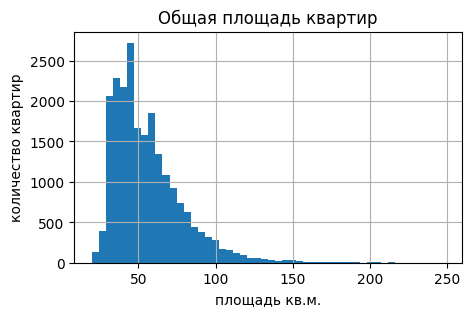

In [67]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['total_area'].hist(bins=50)
ax.set_title('Общая площадь квартир')
ax.set_xlabel('площадь кв.м.')
ax.set_ylabel('количество квартир');

Из гистограммы видно, что больше всего квартир приходится на 50 кв.м., а в районе 200-500 образуется длинный хвост. Убедимся в том, что на большую площадь приходится небольшой набор данных, изменим датафрейм и построим новое распределение. 

In [68]:
round((data[data['total_area'] > 200].shape[0])/data.shape[0]*100, 3)

0.096

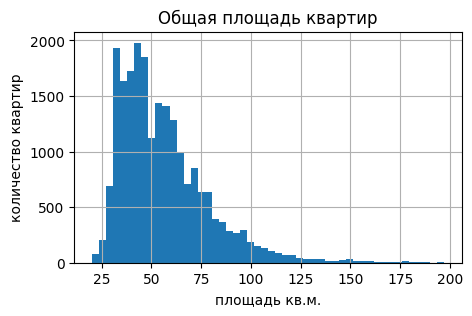

In [69]:
data = data.query('total_area < 200')
fig, ax = plt.subplots(figsize = (5,3))
ax=data['total_area'].hist(bins=50)
ax.set_title('Общая площадь квартир')
ax.set_xlabel('площадь кв.м.')
ax.set_ylabel('количество квартир');

Теперь по графику легче можно отследить, что есть пики в районе 30, 40, 60 и 80 квадратных метров. Скорее всего это связано со стандартизацией постройки: однокомнатные квартиры по стандартному плану должны иметь определённую планировку и иметь площадь 30-40 кв.м. (первые пики), двухкомнатные и трёхкомнатные 60-80 кв.м. Распределение можно назвать норамальным, огромный пик в районе 40 кв.м. объясняется тем, что такие квартиры являются наиболее подходящими по бютжету.

* **Жилая площадь**

Наибольшая жилая площадь 145.4 кв.м.
Наименьшая жилая площадь 5.0 кв.м.


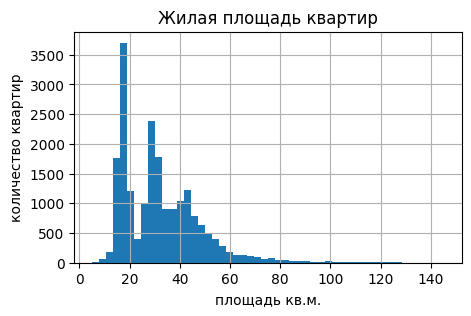

In [70]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['living_area'].hist(bins=50)
ax.set_title('Жилая площадь квартир')
ax.set_xlabel('площадь кв.м.')
ax.set_ylabel('количество квартир')
max_living_area = max(data['living_area'])
min_living_area = min(data['living_area'])
print(f'Наибольшая жилая площадь {max_living_area} кв.м.')
print(f'Наименьшая жилая площадь {min_living_area} кв.м.')

В гистограмме имеются 2 пика. Хвост не такой длинный как на предыдущей гистограмме, поэтому "отрежем" его без изменения датафрейма.

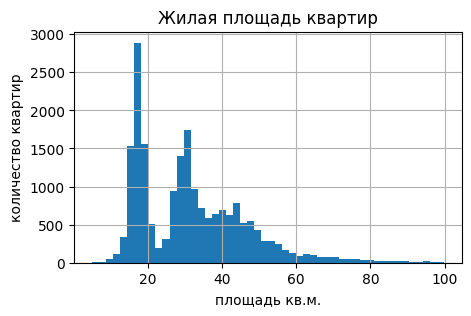

In [71]:
data_living_area = data.query('living_area < 100')
fig, ax = plt.subplots(figsize = (5,3))
ax=data_living_area['living_area'].hist(bins=50)
ax.set_title('Жилая площадь квартир')
ax.set_xlabel('площадь кв.м.')
ax.set_ylabel('количество квартир');

Отчётливо видны пики на значениях ~ 18, 30 и 42 кв.м. Так же резкие спады на ~23 и 35 кв.м. Пики можно объяснить тем, что при стандартной планировке однокомнатных квартир площадью 30-40 кв.м., на жилую площадь приходится порядка 18 кв.м. Далее на двухкомнатные квартиры и трёхкомнатные 30 и 42 кв. м. соответственно. Резкие спады объясняются либо незнанием владельца подсчёта отдельно жилой площади и малым количеством квартир, построенных в свободной планировке.

* **Площадь кухни**

Наибольшая площадь кухни 60.0 кв.м.
Наименьшая площадь кухни 5.0 кв.м.


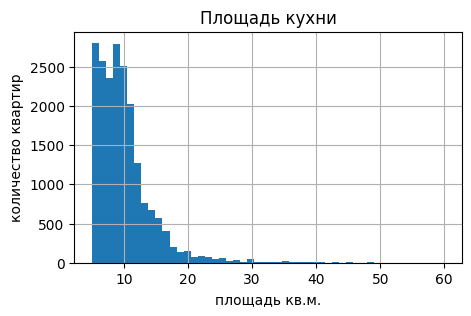

In [72]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['kitchen_area'].hist(bins=50)
ax.set_title('Площадь кухни')
ax.set_xlabel('площадь кв.м.')
ax.set_ylabel('количество квартир')
max_kitchen_area = max(data['kitchen_area'])
min_kitchen_area = min(data['kitchen_area'])
print(f'Наибольшая площадь кухни {max_kitchen_area} кв.м.')
print(f'Наименьшая площадь кухни {min_kitchen_area} кв.м.')

Как и в предыдущем пункте выведем гистаграмму по значениям, которые составляют основную часть гистограммы.

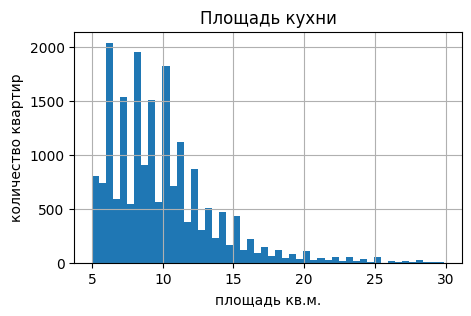

In [73]:
data_kitchen_area = data.query('kitchen_area < 30')
fig, ax = plt.subplots(figsize = (5,3))
ax=data_kitchen_area['kitchen_area'].hist(bins=50)
ax.set_title('Площадь кухни')
ax.set_xlabel('площадь кв.м.')
ax.set_ylabel('количество квартир');

График получился вполне подробный. Много пиков в районе 7-13 кв.м. Действительно порядка 20-25% от общей площади должно приходится на кухну. Из соображений общей площади квартир 30-50 кв.м. на кухню должно приходится как раз 7-13 кв.м.

* **Цена объектов**

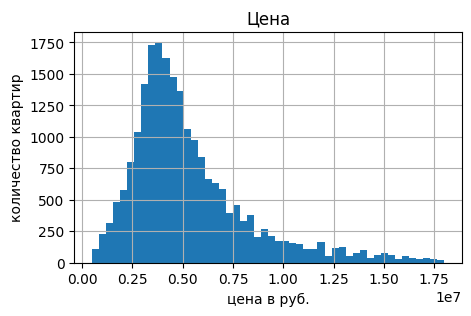

In [74]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['last_price'].hist(bins=50)
ax.set_title('Цена')
ax.set_xlabel('цена в руб.')
ax.set_ylabel('количество квартир');

График получился неподробный. Посмотрим сколько значений приходится на >15 млн. руб.

In [75]:
data_last_price_big = data.query('last_price > 15000000')
len(data_last_price_big)

291

Для лучшей статистики уберём из датафрейма данные значения.

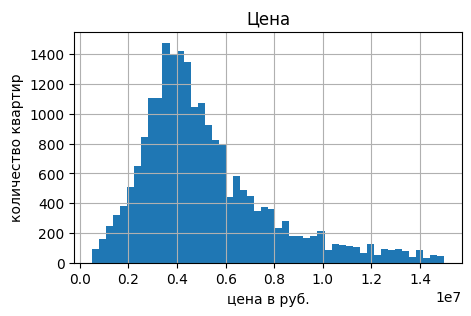

In [76]:
data = data.query('last_price < 15000000')
fig, ax = plt.subplots(figsize = (5,3))
ax=data['last_price'].hist(bins=50)
ax.set_title('Цена')
ax.set_xlabel('цена в руб.')
ax.set_ylabel('количество квартир');

In [77]:
b = data.shape[0]
round((a-b)/a*100,3)

8.886

Построим гистограмму для данных 0-10 млн. руб. без замены самого датафрейма.

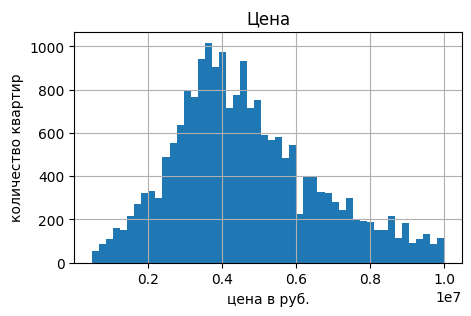

In [78]:
data_last_price_normal = data.query('last_price < 10000000')
fig, ax = plt.subplots(figsize = (5,3))
ax=data_last_price_normal['last_price'].hist(bins=50)
ax.set_title('Цена')
ax.set_xlabel('цена в руб.')
ax.set_ylabel('количество квартир');

График очень хорошо отчерчивает нормальное расспределение. Больше всего значений приходится на 2,5-6 млн.руб. Действительно, больше всего данных у нас о наиболее бютжетных квартирах, а на более дорогие приходится правый "хвост".

* **Количество комнат**

Text(0, 0.5, 'количество квартир')

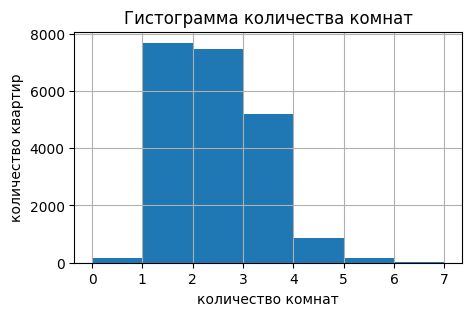

In [79]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['rooms'].hist(bins=7)
ax.set_title('Гистограмма количества комнат')
ax.set_xlabel('количество комнат')
ax.set_ylabel('количество квартир')

На гистограмме хорошо видно, что чаще всего люди покупают и продают однокомнатные и двухкомнатные квартиры. Трёхкомнатные немного реже. Данное распределение вполне можно назвать нормальным. 0 комнат и 4-7 комнат встречаются уже гораздо реже.

* **Высота потолков**

Наибольшая высота потолков 4.0 м.
Наименьшая высота потолков 2.25 м.


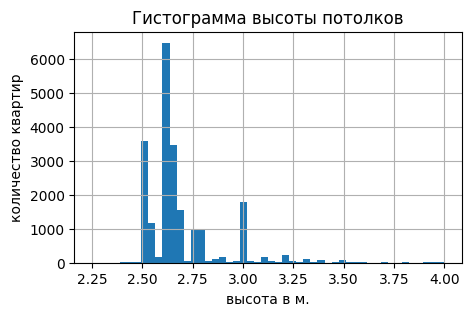

In [80]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['ceiling_height'].hist(bins=50)
ax.set_title('Гистограмма высоты потолков')
ax.set_xlabel('высота в м.')
ax.set_ylabel('количество квартир')
max_ceiling_height = max(data['ceiling_height'])
min_ceiling_height = min(data['ceiling_height'])
print(f'Наибольшая высота потолков {max_ceiling_height} м.')
print(f'Наименьшая высота потолков {min_ceiling_height} м.')

Построим график высоты потолков с верхней границей в 3.25 метра, не изменяя при этом датафрейм.

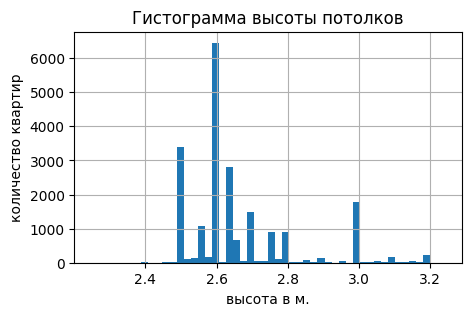

In [81]:
data_ceiling_height = data.query('ceiling_height < 3.25')
fig, ax = plt.subplots(figsize = (5,3))
ax=data_ceiling_height['ceiling_height'].hist(bins=50)
ax.set_title('Гистограмма высоты потолков')
ax.set_xlabel('высота в м.')
ax.set_ylabel('количество квартир');

На гистограмме видно, что самые большие пики приходятся на 2.5, 2.6 и 3 метров. Данные пики могут быть связаны с тем, что старые дома имеют высоту потолков близкую к 3 м., а новостройки около 2.5 м. Так же значительный пик в районе 2.6 метров приходится на заполнение пропущенных значений медианой, так как пропусков в данной категории оказалось практически четверть датафрейма.

* **Этаж**

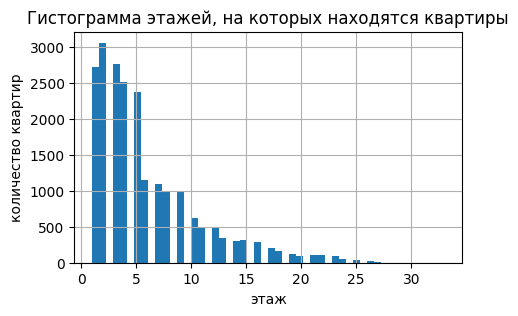

In [82]:
fig, ax = plt.subplots(figsize = (5,3))
ax=data['floor'].hist(bins=50)
ax.set_title('Гистограмма этажей, на которых находятся квартиры')
ax.set_xlabel('этаж')
ax.set_ylabel('количество квартир');

Рассмотрим внимательнее пиковое значение гистограммы. Построим график с этажностью до 18, не изменяя данных датафрейма.

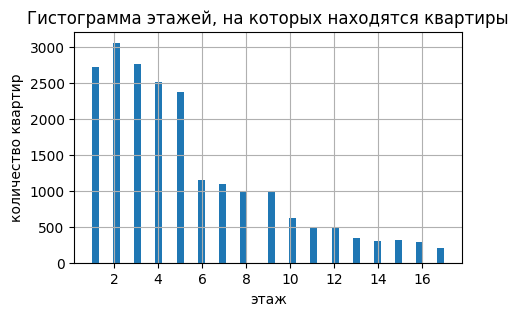

In [83]:
data_floor = data.query('floor < 18')
fig, ax = plt.subplots(figsize = (5,3))
ax=data_floor['floor'].hist(bins=50)
ax.set_title('Гистограмма этажей, на которых находятся квартиры')
ax.set_xlabel('этаж')
ax.set_ylabel('количество квартир');

Пиковые значения в 2-6 объясняются низкой высотностью старых зданий. Длинный хвост свидетельствует о небольшом количестве квартир-новостроек, которые зачастую имеют большую высотность.

* **Тип этажа**

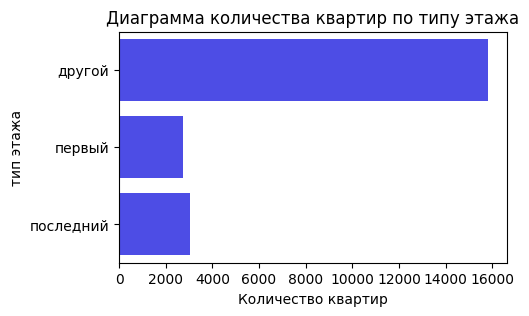

In [84]:
plt.figure(figsize=(5, 3))
sns.countplot(y='floor_type', data = data, color='b', alpha=0.8)
plt.title('Диаграмма количества квартир по типу этажа')
plt.xlabel('Количество квартир')
plt.ylabel('тип этажа')
plt.show() 

Квартир, находящихся на первом или последнем этажах, относительно немного. Это может быть связано с тем, что на первом этаже часто отдают жильё под коммерческую аренду, на последнем этаже высока вероятность протекания крыши. Данные так же можно объяснить предпочтительностью покупателей.

* **Общее количенство этажей в доме**

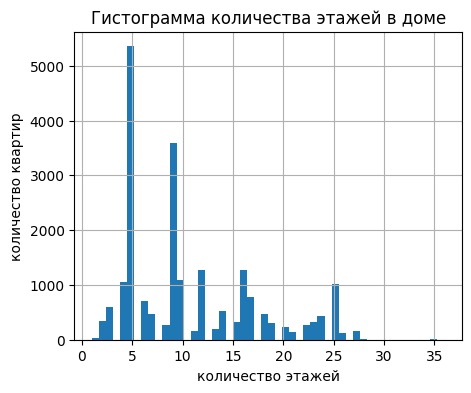

In [85]:
plt.figure(figsize=(5, 4))
ax=data['floors_total'].hist(bins=50)
ax.set_title('Гистограмма количества этажей в доме')
ax.set_xlabel('количество этажей')
ax.set_ylabel('количество квартир');

На гистограмме отчётливые пики у 5, 9, 12 и 16. В 50-е годы преобладали 5-ти этажные постройки, в 70-е начали строить дома более высокие, 9-14 этажей. 16 этажей так же объясняется стандартной постройкой до 80х годов. Новые дома имеют уже более высокую этажность, но пока их не так много, как ранее построенных жилых домов.

* **Расстояние до центра города в метрах**

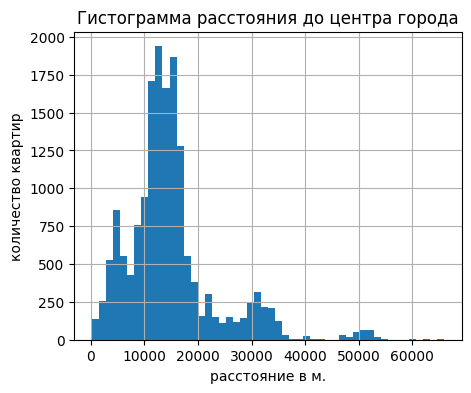

In [86]:
plt.figure(figsize=(5, 4))
ax=data['cityCenters_nearest'].hist(bins=50)
ax.set_title('Гистограмма расстояния до центра города')
ax.set_xlabel('расстояние в м.')
ax.set_ylabel('количество квартир');

Построим гистограмму, ограничиваясь 40.000 метрами.

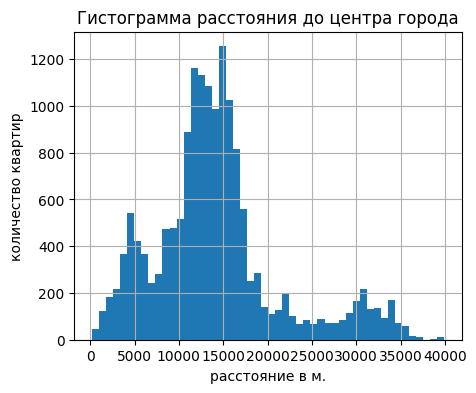

In [87]:
data_cityCenters_nearest = data.query('cityCenters_nearest < 40000')
plt.figure(figsize=(5, 4))
ax=data_cityCenters_nearest['cityCenters_nearest'].hist(bins=50)
ax.set_title('Гистограмма расстояния до центра города')
ax.set_xlabel('расстояние в м.')
ax.set_ylabel('количество квартир');

Будем считать основную часть городов, входящих в наш анализ кроме Санкт-Петербурга, примерной одинаковыми по площади, тогда по гистограмме можно сказать, что квартиры в радиусе 4-х км. 12-ти км. и 15-ти км. продают чаще других.

* **Расстояние до ближайшего аэропорта**.

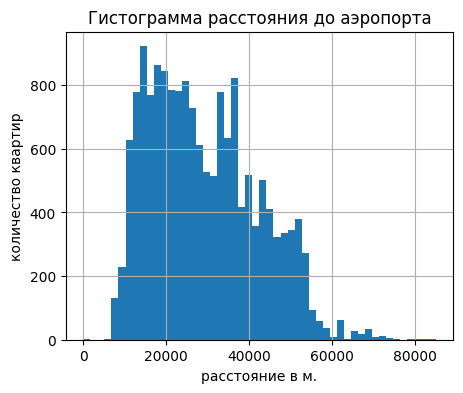

In [88]:
plt.figure(figsize=(5, 4))
ax=data['airports_nearest'].hist(bins=50)
ax.set_title('Гистограмма расстояния до аэропорта')
ax.set_xlabel('расстояние в м.')
ax.set_ylabel('количество квартир');

Если владельцы указывают расстояние до аэропорта, то квартиры находятся в относительной близости к нему, поэтому наш график получился достаточно "полным". Квартиры в основном находятся в районе 10-25-ти и 35-40-ка км.

* **Расстояние до ближайшего парка**.

Наибольшее расстояние до парка 3190.0 м.
Наименьшее расстояние до парка 1.0 м.


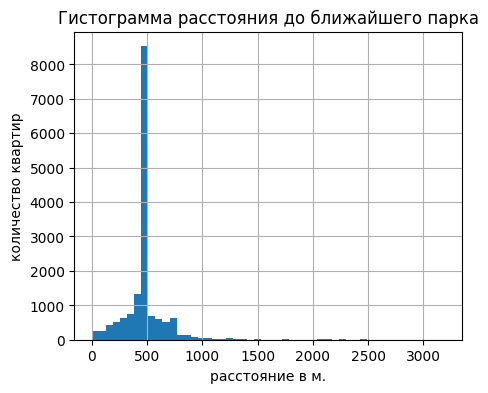

In [89]:
max_parks_nearest = max(data['parks_nearest'])
min_parks_nearest = min(data['parks_nearest'])
print(f'Наибольшее расстояние до парка {max_parks_nearest} м.')
print(f'Наименьшее расстояние до парка {min_parks_nearest} м.')
plt.figure(figsize=(5, 4))
ax=data['parks_nearest'].hist(bins=50)
ax.set_title('Гистограмма расстояния до ближайшего парка')
ax.set_xlabel('расстояние в м.')
ax.set_ylabel('количество квартир');

Ограничимся максимальным расстоянием в 800 метров.

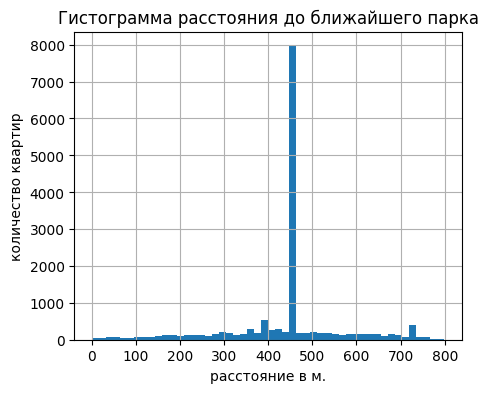

In [90]:
data_parks_nearest = data.query('parks_nearest < 800')
plt.figure(figsize=(5, 4))
ax=data_parks_nearest['parks_nearest'].hist(bins=50)
ax.set_title('Гистограмма расстояния до ближайшего парка')
ax.set_xlabel('расстояние в м.')
ax.set_ylabel('количество квартир');

На гистограмме виден огромный пик в районе 460 метров. Данный пик объясняется так же, как и в высоте потолков, заполнением пропусков медианным значением, только пропусков в данной категории оказалось уже порядка 65%.

* Данные о **дне и месяце публикации объявления**.

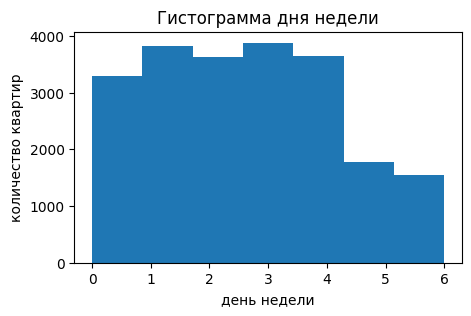

In [91]:
plt.figure(figsize=(5, 3))
ax=data['week_day'].plot(kind='hist', bins=7)
ax.set_title('Гистограмма дня недели')
ax.set_xlabel('день недели')
ax.set_ylabel('количество квартир');

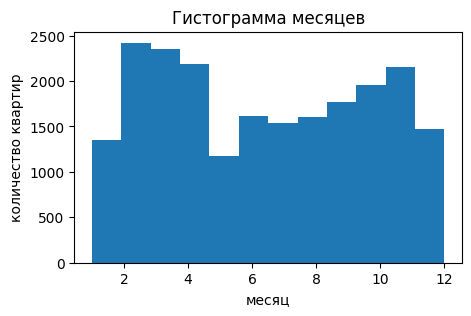

In [92]:
plt.figure(figsize=(5, 3))
ax = data['month'].plot(kind='hist', bins=12)
ax.set_title('Гистограмма месяцев')
ax.set_xlabel('месяц')
ax.set_ylabel('количество квартир');

Продавцы размещают свои объявления преимущественно в рабочие дни.
Так же публикации объявлений приходятся чаще всего на осенний и весенний периоды.

### 4.2. Насколько быстро продавались квартиры.

Построим гистограмму зависимости количества дней, в течение которых были размещены объявления от публикации до снятия. Посчитаем среднее количество, медиану, максимальное и минимальное количество времени публикации.

Среднее значение количества дней - 166.7670548200138 дней.
Медианное значение количества дней 93.0 дней.
Максимальное количество дней размещения объявлений 1000.0 дней.
Минимальное количество дней размещения объявлений  5.0 дней.


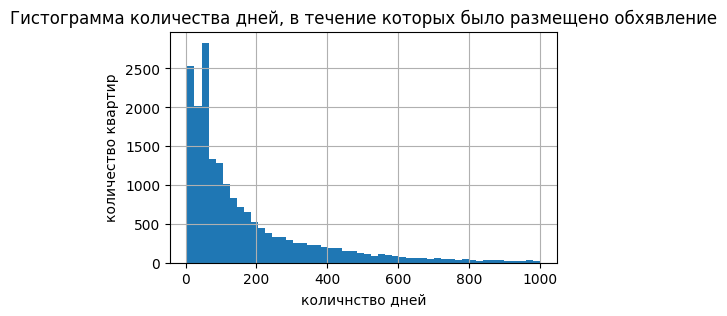

In [93]:
plt.figure(figsize=(5, 3))
ax=data['days_exposition'].hist(bins=50)
ax.set_title('Гистограмма количества дней, в течение которых было размещено обхявление')
ax.set_xlabel('количнство дней')
ax.set_ylabel('количество квартир')
mean_days_exposition = data['days_exposition'].mean()
median_days_exposition = data['days_exposition'].median()
max_days_exposition = data['days_exposition'].max()
min_days_exposition = data['days_exposition'].min()
print(f'Среднее значение количества дней - {mean_days_exposition} дней.')
print(f'Медианное значение количества дней {median_days_exposition} дней.')
print(f'Максимальное количество дней размещения объявлений {max_days_exposition} дней.')
print(f'Минимальное количество дней размещения объявлений  {min_days_exposition} дней.');

Рассмотрим гистограммs в районе 0-400 дней и 0-200 дней, не изменяя датафрейм.

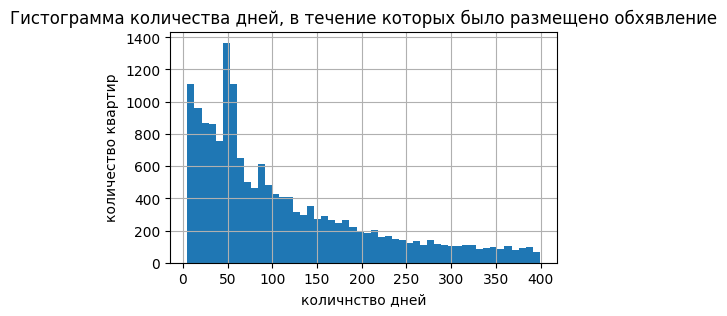

In [94]:
data_days_exposition_400 = data.query('days_exposition < 400')
plt.figure(figsize=(5, 3))
ax=data_days_exposition_400['days_exposition'].hist(bins=50)
ax.set_title('Гистограмма количества дней, в течение которых было размещено обхявление')
ax.set_xlabel('количнство дней')
ax.set_ylabel('количество квартир');

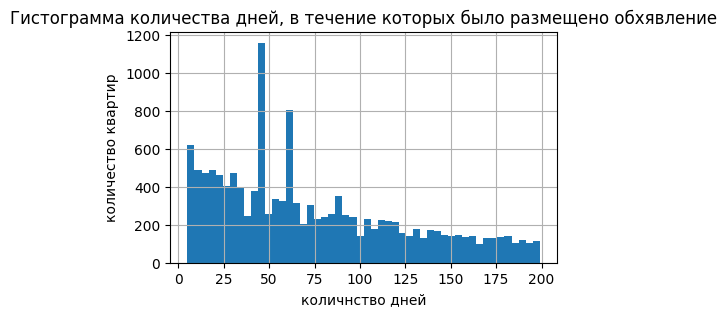

In [95]:
data_days_exposition_200 = data.query('days_exposition < 200')
plt.figure(figsize=(5, 3))
ax=data_days_exposition_200['days_exposition'].hist(bins=50)
ax.set_title('Гистограмма количества дней, в течение которых было размещено обхявление')
ax.set_xlabel('количнство дней')
ax.set_ylabel('количество квартир');

In [96]:
data['days_exposition'].describe()

count    18807.000000
mean       166.767055
std        185.283228
min          5.000000
25%         45.000000
50%         93.000000
75%        219.000000
max       1000.000000
Name: days_exposition, dtype: float64

Чаще всего продажа занимает 45 и 60 дней. Исходя из первого графика быстрыми можно считать продажи менее, чем за 44 дня дней. Медленными же продажами являются более 217 дней. В среднем продают квартиры за 95 дней.

### 4.3. Какие факторы больше всего влияют на общую (полную) стоимость объекта

* Посмотрим как зависит цена от общей площади. Построим точечный график зависимости цены от общей площади.

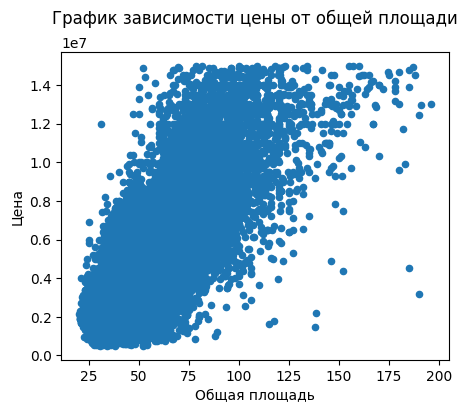

In [97]:
ax=data.plot(x='total_area', y='last_price', kind='scatter', figsize=(5, 4))
ax.set_title('График зависимости цены от общей площади', pad=20)
ax.set_xlabel('Общая площадь')
ax.set_ylabel('Цена');

Посчитаем коэффициент корреляции.

In [98]:
round(data['total_area'].corr(data['last_price']), 2)

0.75

С увеличением общей площади цена безусловно растёт. Среди значений с большыми площадями график менее густой. Это связано с небольшим количеством больших квартир. Сильно выбивающиеся значения отражают цены в крупных городах. В подтверждение пункта 4.1. можно сказать что диапазон цен простирается в районе 2,5-6 млн. рублей. Так же коэффициент корреляции довольно велик, что говорит о значильной зависимости между общей площадью квартир и их ценой.

* Посмотрим как зависит цена от жилой площади.

<Figure size 500x300 with 0 Axes>

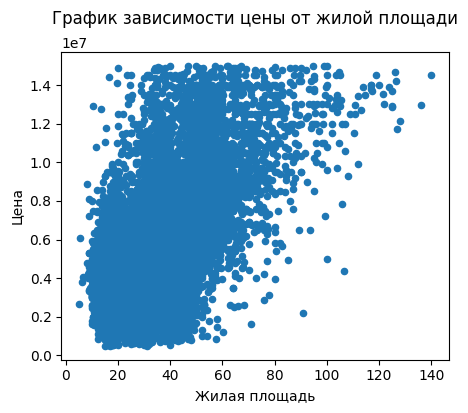

In [99]:
plt.figure(figsize=(5, 3))
ax=data.plot(x='living_area', y='last_price', kind='scatter', figsize=(5, 4))
ax.set_title('График зависимости цены от жилой площади', pad=20)
ax.set_xlabel('Жилая площадь')
ax.set_ylabel('Цена');

Посчитаем коэффициент корреляции.

In [100]:
round(data['living_area'].corr(data['last_price']), 2)

0.63

Зависимость цены от жилой площади получилась более непредсказуемая. Достаточно много пиковых значений. Само распределение имеет равномерную густоту в районе цены до 6 млн. руб. и значений площади менее 80 кв. м. Выбивающиеся значения могут быть свидетельством свободной планировки или типом квартир как аппартаменты. Коэффициент корреляции получился немного меньше, чем у общей площади, но коррелиция заметная.

* Выясним есть ли зависимость между ценой квартир и площадью кухни.

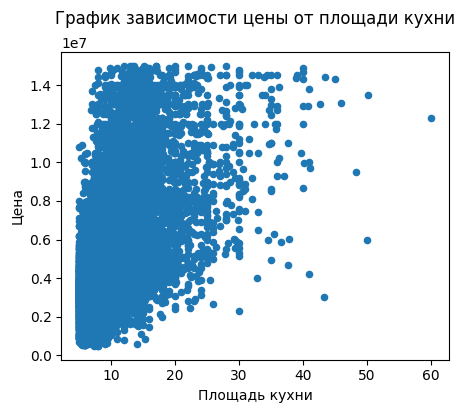

In [101]:
ax = data.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(5, 4))
ax.set_title('График зависимости цены от площади кухни', pad=20)
ax.set_xlabel('Площадь кухни')
ax.set_ylabel('Цена');

Приблизим график.

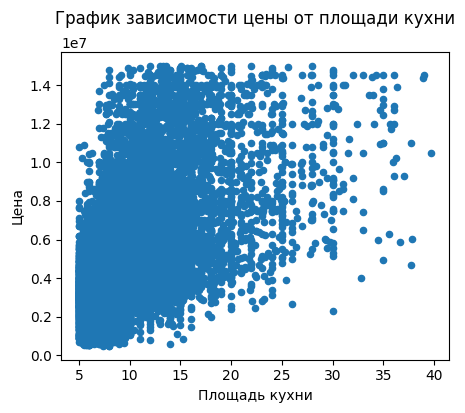

In [102]:
ax = data.query('kitchen_area < 40').plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(5, 4))
ax.set_title('График зависимости цены от площади кухни')
ax.set_xlabel('Площадь кухни')
ax.set_ylabel('Цена')
plt.title(label='График зависимости цены от площади кухни', pad=20);

Посчитаем коэффициент корреляции.

In [103]:
round(data['kitchen_area'].corr(data['last_price']), 2)

0.54

Так как на кухню обычно приходится 20-25%, то график имеет большую густоту в значениях менее 20 кв.м. Выбивающиеся значения больших площадей кухонь могут описывать квартиры свободной планировки и квартиры большой общей площади. Корреляция величин заметная.

* Рассмотрим зависимость цены от количества комнат.

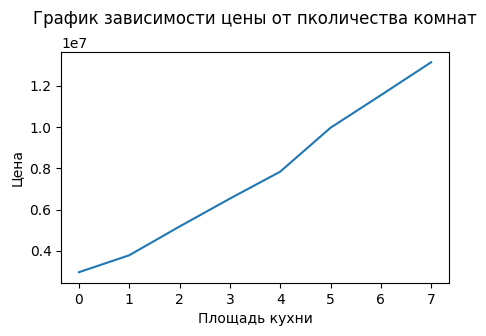

In [104]:
plt.figure(figsize=(5, 3))
ax = data.groupby('rooms')['last_price'].mean().plot()
ax.set_title('График зависимости цены от количества комнат')
ax.set_xlabel('Площадь кухни')
ax.set_ylabel('Цена')
plt.title(label='График зависимости цены от пколичества комнат', pad=20);

На графике видно, что с увеличением количества комнат цена равномерно растёт.

In [105]:
round(data['rooms'].corr(data['last_price']), 2)

0.49

Коэффициент корреляции оказался небольшим, что говорит о том, что зависимость не совсем линейная.

* Зависимость цены от типа этажа, на котором находится квартира.

Медианное значение floor_type
другой       5.358103e+06
первый       4.266446e+06
последний    4.825591e+06
Name: last_price, dtype: float64
Среднее значение floor_type
другой       5.358103e+06
первый       4.266446e+06
последний    4.825591e+06
Name: last_price, dtype: float64


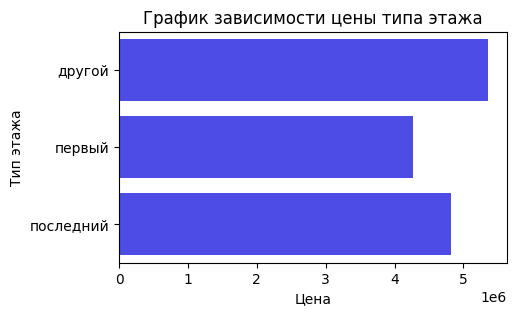

In [106]:
data['floor_type'].value_counts()
data_floor_type = data.pivot_table(index='floor_type', values='last_price').reset_index()
data_floor_type.columns = ['floor_type', 'last_price']
plt.figure(figsize=(5, 3))
ax = sns.barplot(y='floor_type',x='last_price',data = data_floor_type, color='b', alpha=0.8)
ax.set_title('График зависимости цены типа этажа')
ax.set_xlabel('Цена')
ax.set_ylabel('Тип этажа');

median = data_floor_type.groupby('floor_type')['last_price'].median()
mean = data_floor_type.groupby('floor_type')['last_price'].mean()
print(f'Медианное значение {median}')
print(f'Среднее значение {mean}')

Квартиры, находящиеся на первом этаже значительнее дешевле остальных. Квартиры на последнем немного дешевле других квартир.

* Зависимость от даты размещения.

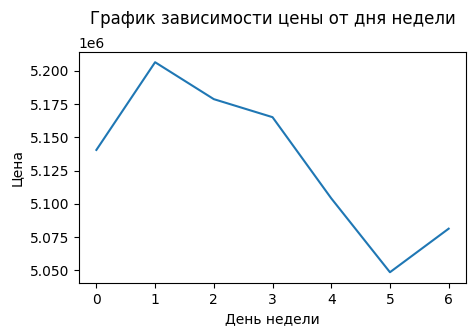

In [107]:
plt.figure(figsize=(5, 3))
ax = data.groupby('week_day')['last_price'].mean().plot()
ax.set_title('График зависимости цены от дня недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Цена')
plt.title(label='График зависимости цены от дня недели', pad=20);

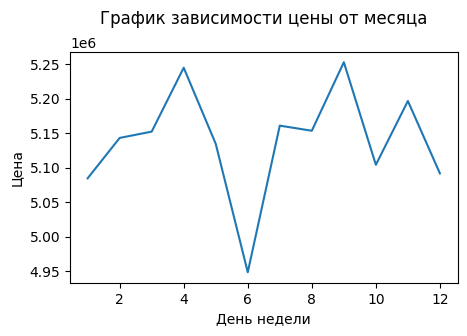

In [108]:
plt.figure(figsize=(5, 3))
ax = data.groupby('month')['last_price'].mean().plot()
ax.set_title('График зависимости цены от месяца')
ax.set_xlabel('День недели')
ax.set_ylabel('Цена')
plt.title(label='График зависимости цены от месяца', pad=20);

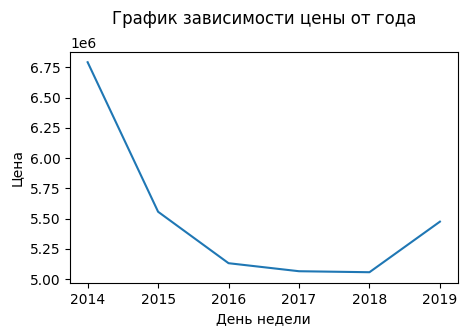

In [109]:
plt.figure(figsize=(5, 3))
ax = data.groupby('year')['last_price'].mean().plot()
ax.set_title('График зависимости цены от года')
ax.set_xlabel('День недели')
ax.set_ylabel('Цена')
plt.title(label='График зависимости цены от года', pad=20);

По графикам можно сказать что цена квартиры к концу недели снижается, так же снижается в летние месяцы и с 2014-2018 снижалась и затем немного росла.

Посмотрим на зависимомть между общей площадью квартир и годом публикации объявлений.

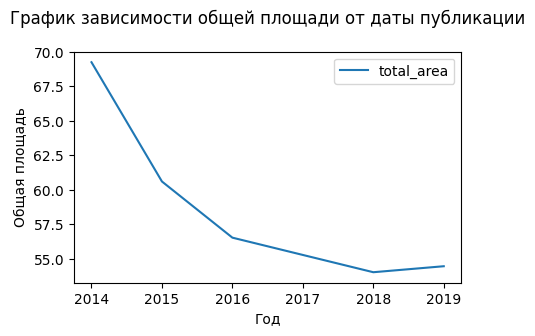

In [110]:
ax = data.pivot_table(index='year', values='total_area').plot(figsize=(5, 3))
ax.set_title('График зависимости общей площади от даты публикации')
ax.set_xlabel('Год')
ax.set_ylabel('Общая площадь')
plt.title(label='График зависимости общей площади от даты публикации', pad=20);

По графикам можно увидеть, что в 2014 году выкладывали самые большие квартиры и затем площадь выкладываемых квартир снижалась. Если сервис был открыт в 2014 году, то количество объявлений было совсем небольшим, сервис ещё не набрал популярность, потом количество объявлений начало расти вплоть до 2018 года и испытало резкий спад в 2019 году. Таким образом это может непосредственно влиять на стоимость квартир. Квартиры с небольшой площадью дешевле. Так же в 2014 году небольшое количество объявлений с большими площадями могут сильно влиять на график зависимости цены от года, как и сильно выбивающиеся 2018 и 2019 года.

### 4.4. Посчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

Составим сводную таблицу

In [111]:
new_data = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc = ['mean', 'count']).reset_index()
new_data.columns = ['locality_name', 'mean','count']
new_data = new_data.query('count > 200')
new_data.sort_values('mean')

,locality_name,mean,count
4,Выборг,57998.283419,227
3,Всеволожск,67241.995789,382
6,Гатчина,68840.815123,293
13,Колпино,75193.139227,327
271,поселок Шушары,78548.412376,427
213,поселок Мурино,85393.815123,525
220,поселок Парголово,90146.174201,317
91,деревня Кудрово,92377.665435,286
32,Пушкин,100546.983677,331
33,Санкт-Петербург,106980.650436,13964


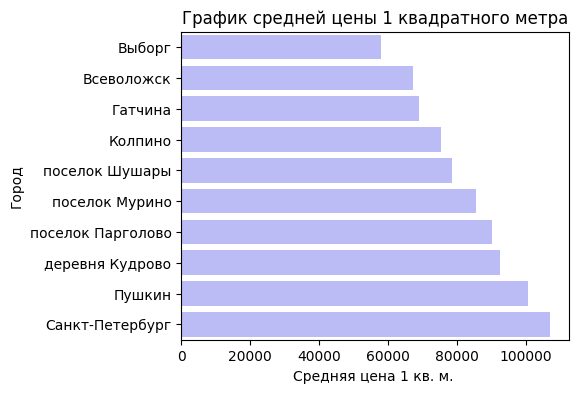

In [112]:
plt.figure(figsize=(5, 4))
ax = sns.barplot(y='locality_name',x='mean',data = new_data.sort_values('mean'), color='b', alpha=0.3)
ax.set_title('График средней цены 1 квадратного метра')
ax.set_xlabel('Средняя цена 1 кв. м. ')
ax.set_ylabel('Город');

Населенный пункт с самой низкой стоимостью квадратного метра - Выборг.
Населенный пункт с самой высокой стоимостью квадратного метра - Санкт-Петербург.

### 4.5. Подсчет средней цены 1 км. в городе Санкт-Петербург.

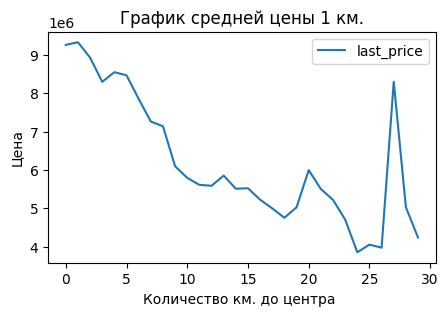

In [113]:
table_SPB = data.loc[data['locality_name'] == 'Санкт-Петербург']
ax = table_SPB.pivot_table(index='cityCenters_nearest_km', values='last_price').plot(figsize=(5, 3))
ax.set_title('График средней цены 1 км.')
ax.set_xlabel('Количество км. до центра ')
ax.set_ylabel('Цена');

По мере отдаления от центра цена неравномерно снижалась и резко возрасла на 20-м км. и 27-м км. Посмотрим какие квартиры распологаются в радиусе примерно 27 км. от центра Санкт-Петербурга.

In [114]:
table_SPB[table_SPB['cityCenters_nearest_km'] == 27]['last_price']

748     14350000.0
5961     2250000.0
Name: last_price, dtype: float64

На 27м километре распологаются две дорогие квартиры, которые дают значительный вклад в график.

## 5. Общий вывод.<a id='section_id_5'></a>

Нам был предоставлен датафрейм сервиса Яндекс.Недвижимости - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Перед нами стояла задача научиться определять рыночную стоимость объектов недвижимости. То есть установить параметры, от которых зависит стоимость объектов.
На этапе предобработки данных мы заполнили пропуски, где это было возможно, изменили типы данных, избавились от неявных дубликатов и изучили аномальные значения.


После проведения исследовательского анализа данных были сделаны следующие выводы:
* Больше всего квартир приходится на ценовой диапазон 2,5-6 млн. руб., количество комнат в таких квартирах - 1-3, этаж 2-6, расстояние до центра 4-15км, расстояние до аэропорта 10-25 или 35-40км. Публикация объявлений приходится на рабочие дни, осенние и весенние месяцы.
* Цена увеличивается с увеличением общей площади, количества комнат. Квартиры на первом этаже дешевле других. Так же квартиры на последнем этаже чаще дешевле остальных. Цена квартир к концу недели снижается. Так же снижается в летние месяцы. 
* По цене за квадратный метр самый дешевый город - Выборг, самый дорогой - Санкт-Петербург.
* В Санкт-Петербурге самые дорогие квартиры находятся в центре и по мере удаления от центра цена квартир снижается.